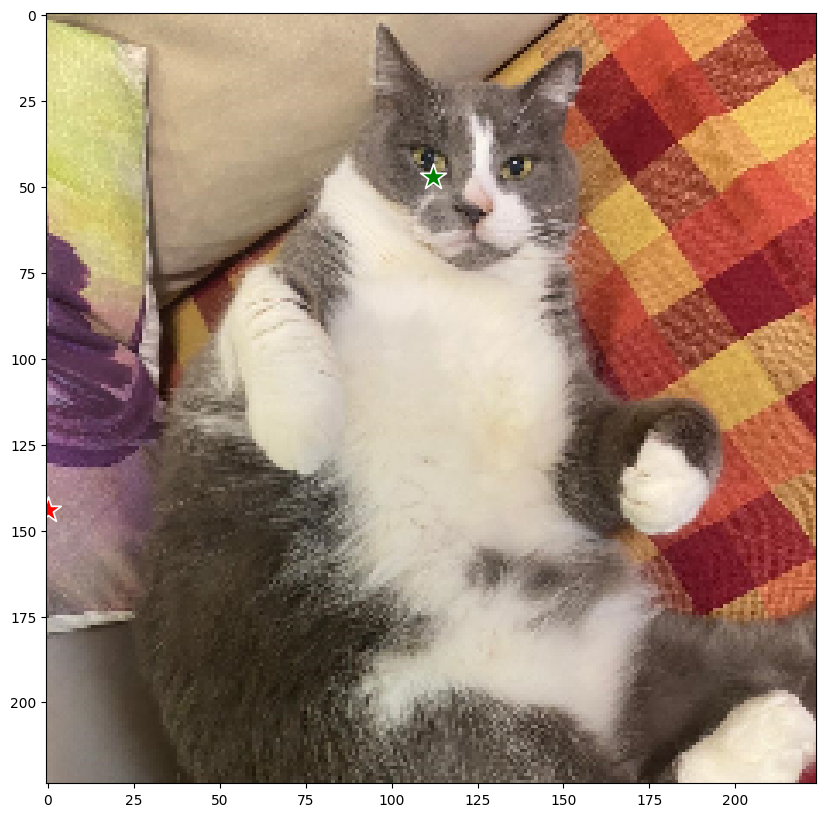

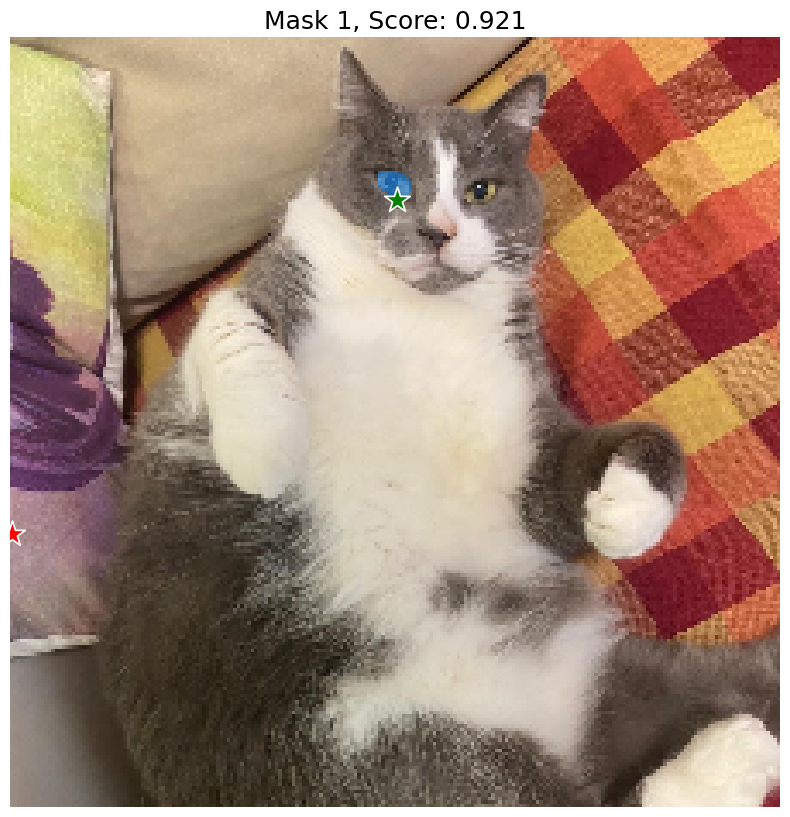

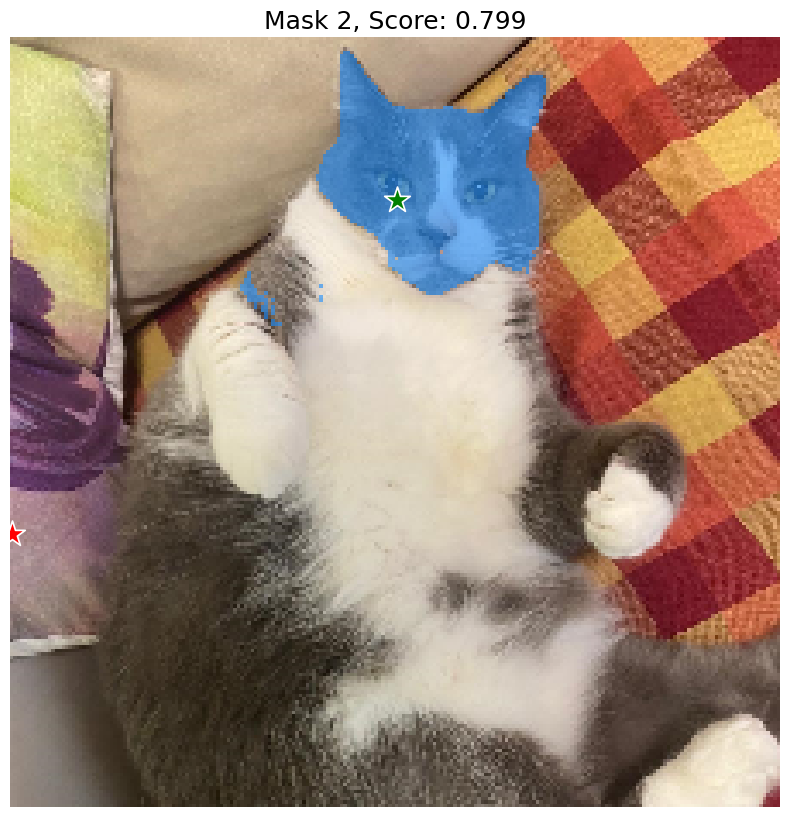

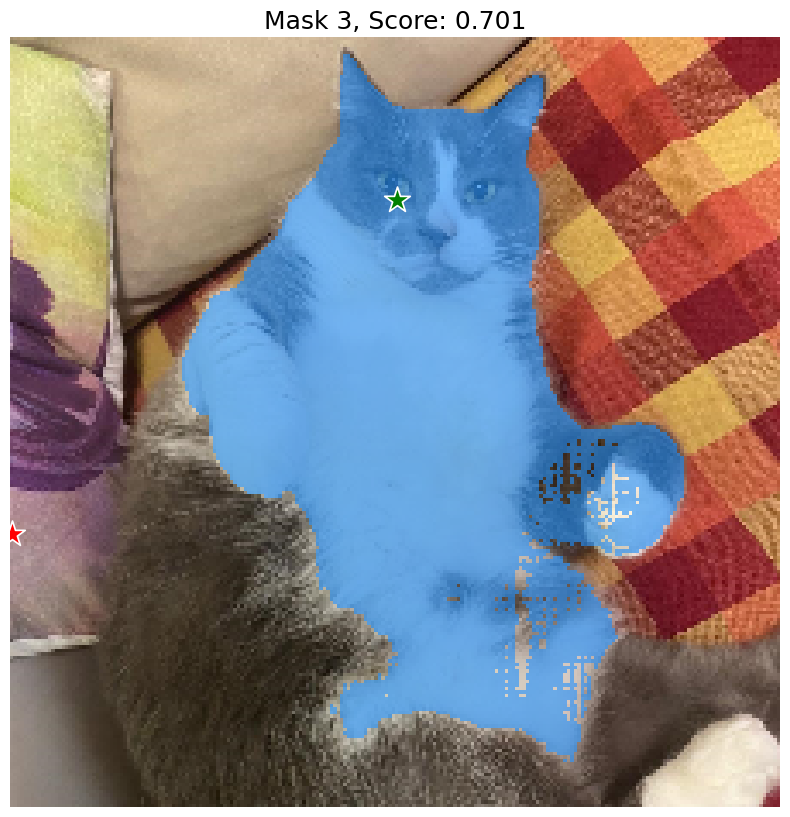

In [25]:
import cv2
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
image_folder = "/home/yujr/workstation/Audio-Visual-Seg/avs_scripts/avs_s4_aclp/zero_shot_inference/images"
from segment_anything import build_sam, SamPredictor
from model import AudioCLIP, AudioCLIP_Surgery
import torchvision as tv
from PIL import Image
import utils
import simplejpeg

img_name = 'cat_2.jpg'
audio_name = 'cat_3-95694-A-5.wav'
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

def show_heatmap(img, similarity):
    img = cv2.resize(img, (224, 224))
    heatmap = similarity[0][0].cpu().detach().numpy()
    vis = (heatmap * 255).astype('uint8')
    vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
    vis = img * 0.4 + vis * 0.6
    vis = vis.astype('uint8')
    cv2.imwrite('heatmap.jpg', vis)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


######
## build_sam
sam_checkpoint = '../../pretrained_backbones/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
######

######
## build_audioclip
aclp = AudioCLIP_Surgery(pretrained='../../pretrained_backbones/AudioCLIP-Full-Training.pt')
aclp.eval()
visual_encoder = aclp.visual
audio_encoder = aclp.audio
SAMPLE_RATE = 44100
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

image_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC),
    tv.transforms.CenterCrop(IMAGE_SIZE),
    tv.transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])
audio_transforms = utils.transforms.ToTensor1D()
######

######
## load image
image = cv2.imread(os.path.join(image_folder, img_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
predictor.set_image(image)

with open(os.path.join(image_folder, img_name), 'rb') as jpg:
    image_ = simplejpeg.decode_jpeg(jpg.read())
    image_ = image_transforms(image_)
    image_ = image_.unsqueeze(0)
image_ = image_.to(device=device)

######
## gen a noise
def gen_noise(percent=0.2):
    np.random.seed(0)
    random_values = np.random.rand(220500)
    return torch.tensor(percent * random_values).float().unsqueeze(0).cuda()
#####
import librosa
path_to_audio = "../avs_s4_aclp/zero_shot_inference/audio/{}".format(audio_name)
track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)
audio = audio_transforms(track.reshape(1, -1))
audio = audio.cuda()
aclp.to(device=device)
redundant_noise = gen_noise()
######

#########
# get point prompt
audio_features = aclp.encode_audio(audio=audio)
redundant_features = aclp.encode_audio(audio=redundant_noise)
audio_features = audio_features / audio_features.norm(dim=-1, keepdim=True)
redundant_features = redundant_features / redundant_features.norm(dim=-1, keepdim=True)
audio_features = audio_features - redundant_features
feature_map, visual_features = aclp.encode_image(image=image_)
region_feature = feature_map[-1]
region_feature = region_feature / region_feature.norm(dim=1, keepdim=True)
audio_features = audio_features.unsqueeze(2).unsqueeze(3) # batch x 1024 x 1 x 1
audio_features = audio_features.expand(-1, -1, region_feature.shape[2], region_feature.shape[3])
similarity = torch.sum(audio_features * region_feature, dim=1)
sm = (similarity - similarity.min()) / (similarity.max() - similarity.min())
sm = sm.unsqueeze(0)
sm = torch.nn.functional.interpolate(sm, (IMAGE_SIZE, IMAGE_SIZE), mode='bilinear')
show_heatmap(image, sm)

#########
sm = sm.reshape((-1, 224*224))
# pos points
score, indices = sm.topk(1, dim=-1)
indices = indices.cpu().numpy()
points = []
for batch in range(sm.shape[0]):
    for index in indices[batch]:
        points.append([index % 224, index // 224])
# neg points
score, indices = sm.topk(1, dim=-1, largest=False)
indices = indices.cpu().numpy()
for batch in range(sm.shape[0]):
    for index in indices[batch]:
        points.append([index % 224, index // 224])
input_point = np.array(points)
input_label = np.array([1, 0])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  


